<a href="https://colab.research.google.com/github/notnsas/cautious-eureka/blob/main/aplikasi_ds/Model_tambahan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import library**

In [ ]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split, cross_val_score, GridSearchCV
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve
)

import matplotlib.pyplot as plt
import seaborn as sns # Untuk visualisasi yang lebih menarik
import graphviz # Untuk visualisasi graphviz
import nltk # Untuk pra-pemrosesan teks lebih lanjut
from nltk.stem import WordNetLemmatizer # Untuk lemmatization
from nltk.corpus import stopwords as nltk_stopwords # Untuk custom stop words

# Feature selection
from sklearn.feature_selection import SelectKBest, chi2

# Download resource NLTK yang mungkin dibutuhkan
# Catch the LookupError directly when nltk.data.find fails
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    print("NLTK resource 'wordnet' not found. Downloading...")
    nltk.download('wordnet')
except Exception as e:
    print(f"An unexpected error occurred while checking/downloading 'wordnet': {e}")

try:
    nltk.data.find('corpora/omw-1.4')
except LookupError:
    print("NLTK resource 'omw-1.4' not found. Downloading...")
    nltk.download('omw-1.4') # WordNet multilingual resource
except Exception as e:
    print(f"An unexpected error occurred while checking/downloading 'omw-1.4': {e}")

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    print("NLTK resource 'stopwords' not found. Downloading...")
    nltk.download('stopwords')
except Exception as e:
    print(f"An unexpected error occurred while checking/downloading 'stopwords': {e}")

# Smote
from imblearn.over_sampling import SMOTE

# PYtorch
import torch
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Random
import random

#Import svm model
from sklearn import svm

# Logistic regression
# import the class
from sklearn.linear_model import LogisticRegression

# Pengaturan umum untuk plot agar lebih menarik
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis") # Atau palet lain seperti 'pastel', 'muted'

NLTK resource 'wordnet' not found. Downloading...
NLTK resource 'omw-1.4' not found. Downloading...


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


NLTK resource 'stopwords' not found. Downloading...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## **Load dataset**

In [ ]:
# path = 'https://raw.githubusercontent.com/LatiefDataVisionary/text-mining-and-natural-language-processing-college-task/refs/heads/main/datasets/ramadan_labeled_sentiment.csv'
path = 'https://raw.githubusercontent.com/notnsas/cautious-eureka/refs/heads/main/dataset/data_3_kelas_real.csv'
df = pd.read_csv(path)

print(f"Dataset berhasil di-load dari: {path}")
print(f"Jumlah baris: {df.shape[0]}, Jumlah kolom: {df.shape[1]}")

Dataset berhasil di-load dari: https://raw.githubusercontent.com/notnsas/cautious-eureka/refs/heads/main/dataset/data_3_kelas_real.csv
Jumlah baris: 836, Jumlah kolom: 11


In [ ]:
df

,tweet_clean,Tweet,sentiment,neg,neu,pos,compound
0,"['abraj', 'al', 'bait', 'clock', 'tower', 'bea...",abraj al bait clock tower beams indicating com...,neutral,0.000,1.000,0.000,0.0000
1,"['accounts', 'recognised', 'ramadan', 'none', ...",accounts recognised ramadan none recognised be...,negative,0.147,0.853,0.000,-0.4767
2,"['admin', 'post', 'peaceful', 'ramadan', 'cele...",admin post peaceful ramadan celebrations east ...,positive,0.000,0.714,0.286,0.4939
3,"['admin', 'post', 'ramadan', 'norway']",admin post ramadan norway,neutral,0.000,1.000,0.000,0.0000
4,"['admin', 'post', 'ramadan', 'usual', 'peacefu...",admin post ramadan usual peaceful start englan...,positive,0.000,0.775,0.225,0.4939
...,...,...,...,...,...,...,...
831,"['ya', 'allah', 'please', 'remove', 'procrasti...",ya allah please remove procrastination body ra...,positive,0.171,0.348,0.481,0.8689
832,"['yaqeen', 'launched', 'official', 'urdu', 'yo...",yaqeen launched official urdu youtube channel ...,positive,0.000,0.688,0.312,0.7003
833,"['yasser', 'abu', 'daqqa', 'recently', 'freed'...",yasser abu daqqa recently freed palestinian de...,negative,0.336,0.494,0.170,-0.7506
834,"['young', 'arabs', 'took', 'streets', 'last', ...",young arabs took streets last night shouting a...,negative,0.190,0.747,0.063,-0.6597


## **Preprocessing**

In [ ]:
print("Label sentimen sebelum konversi:")
print(df['sentiment'].unique()) # Menampilkan nilai unik sebelum mapping

df['sentiment_label'] = df['sentiment'].copy() # Simpan label asli untuk referensi
df['sentiment'] = df['sentiment'].map({'neutral':2, 'positive': 1, 'negative' : 0})
# df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative' : 0})

print("\nLabel sentimen setelah konversi ke numerik (0 dan 1):")
print(df['sentiment'].unique()) # Menampilkan nilai unik setelah mapping
display(df[['Tweet', 'sentiment_label', 'sentiment']].head())

Label sentimen sebelum konversi:
[2 1 0]

Label sentimen setelah konversi ke numerik (0 dan 1):
[nan]


,Tweet,sentiment_label,sentiment
0,abraj al bait clock tower beams indicating com...,2,NaN
1,accounts recognised ramadan none recognised be...,2,NaN
2,admin post peaceful ramadan celebrations east ...,2,NaN
3,admin post ramadan norway,2,NaN
4,admin post ramadan usual peaceful start englan...,2,NaN


In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
2,693
1,126
0,17


,count
sentiment,
positive,441
neutral,234
negative,161


In [ ]:
# Fungsi untuk menggabungkan list kata menjadi string
def join_text_list(text_list_str):
    if isinstance(text_list_str, str):
        try:
            actual_list = eval(text_list_str)
            if isinstance(actual_list, list):
                return ' '.join(actual_list)
            else:
                # Jika eval menghasilkan bukan list (misalnya, sudah string utuh)
                return str(text_list_str) # Kembalikan sebagai string
        except Exception: # Tangkap error lebih umum dari eval
            return str(text_list_str) # Kembalikan string aslinya jika eval gagal
    elif isinstance(text_list_str, list):
        return ' '.join(text_list_str)
    return str(text_list_str) # Pastikan output selalu string

df['text_processed_raw'] = df['tweet_clean'].apply(join_text_list)

# Inisialisasi Lemmatizer dan Stop Words
lemmatizer = WordNetLemmatizer()
english_stopwords = set(nltk_stopwords.words('english'))
# Anda bisa tambahkan custom stop words di sini jika perlu
# custom_stopwords = {'ramadan', 'mubarak', ...}
# all_stopwords = english_stopwords.union(custom_stopwords)

def preprocess_text_advanced(text):
    if not isinstance(text, str): # Pastikan input adalah string
        return ""
    words = text.split() # Tokenisasi sederhana
    # Lemmatisasi dan penghapusan stop words
    processed_words = [lemmatizer.lemmatize(word.lower()) for word in words if word.lower() not in english_stopwords and word.isalpha()] # Hanya ambil kata alpha
    return ' '.join(processed_words)

print("\nMenerapkan pra-pemrosesan teks lanjutan (lemmatization, stop word removal)...")
df['text_processed'] = df['text_processed_raw'].apply(preprocess_text_advanced)

print("\nContoh hasil 'text_processed' setelah pra-pemrosesan lanjutan:")
display(df[['tweet_clean', 'text_processed_raw', 'text_processed']].head())


Menerapkan pra-pemrosesan teks lanjutan (lemmatization, stop word removal)...

Contoh hasil 'text_processed' setelah pra-pemrosesan lanjutan:


,tweet_clean,text_processed_raw,text_processed
0,"['abraj', 'al', 'bait', 'clock', 'tower', 'bea...",abraj al bait clock tower beams indicating com...,abraj al bait clock tower beam indicating comm...
1,"['accounts', 'recognised', 'ramadan', 'none', ...",accounts recognised ramadan none recognised be...,account recognised ramadan none recognised beg...
2,"['admin', 'post', 'peaceful', 'ramadan', 'cele...",admin post peaceful ramadan celebrations east ...,admin post peaceful ramadan celebration east l...
3,"['admin', 'post', 'ramadan', 'norway']",admin post ramadan norway,admin post ramadan norway
4,"['admin', 'post', 'ramadan', 'usual', 'peacefu...",admin post ramadan usual peaceful start englan...,admin post ramadan usual peaceful start englan...


In [ ]:
# # --- MULAI KODE UNTUK LANGKAH 1: PREPROCESSING TEKS ---
# # Pastikan NLTK resources sudah ada atau diunduh
# # (Kode ini sebaiknya ada di awal notebook, saya sertakan di sini untuk kelengkapan)
# import nltk

# # Explicitly download required NLTK resources
# nltk.download('wordnet', quiet=True)
# nltk.download('omw-1.4', quiet=True)
# nltk.download('stopwords', quiet=True)
# nltk.download('punkt', quiet=True)
# nltk.download('punkt_tab', quiet=True)


# # Import library yang relevan untuk tahap ini
# import re
# from nltk.tokenize import word_tokenize
# from nltk.stem import PorterStemmer # Menggunakan PorterStemmer untuk stemming
# from nltk.corpus import stopwords as nltk_stopwords
# from nltk.stem import WordNetLemmatizer # Import WordNetLemmatizer

# # pandas dan WordNetLemmatizer sudah diimport sebelumnya

# # Fungsi untuk menggabungkan list kata menjadi string (masih relevan dari kode awal Anda)
# def join_text_list(text_list_str):
#     if isinstance(text_list_str, str):
#         try:
#             actual_list = eval(text_list_str)
#             if isinstance(actual_list, list):
#                 return ' '.join(actual_list)
#             else:
#                 return str(text_list_str)
#         except Exception:
#             return str(text_list_str)
#     elif isinstance(text_list_str, list):
#         return ' '.join(text_list_str)
#     return str(text_list_str)

# # Mengaplikasikan join_text_list ke kolom 'tweet_clean' untuk mendapatkan teks mentah
# # yang akan diproses. Kolom ini digunakan agar proses evaluasi lebih konsisten
# # dengan bagaimana 'text_processed_raw' dibuat di kode asli.
# df['text_processed_raw'] = df['tweet_clean'].apply(join_text_list)


# # Inisialisasi Lemmatizer dan Stop Words
# # Menggunakan WordNetLemmatizer untuk lemmatization
# lemmatizer = WordNetLemmatizer()
# english_stopwords = set(nltk_stopwords.words('english'))
# # Anda bisa tambahkan custom stop words di sini jika perlu, contoh:
# # custom_stopwords = {'ramadan', 'mubarak', 'also', 'like', 'would'}
# # all_stopwords = english_stopwords.union(custom_stopwords)
# # Untuk saat ini, kita gunakan default NLTK English stopwords

# def preprocess_text_step1(text):
#     if not isinstance(text, str): # Pastikan input adalah string
#         return ""

#     # 1. Case Folding: Mengubah semua teks menjadi huruf kecil
#     text = text.lower()

#     # Tambahan: Menghilangkan URL, mention, hashtag (opsional, tapi baik untuk tweet)
#     text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE) # Menghilangkan URL
#     text = re.sub(r'\@\w+|\#','', text) # Menghilangkan mention dan hashtag symbols

#     # Tambahan: Menghilangkan karakter non-alfanumerik kecuali spasi (menyisakan kata dan angka)
#     # Jika ingin hanya alphabet: text = re.sub(r'[^a-zA-Z\s]', '', text)
#     text = re.sub(r'[^a-zA-Z0-9\s]', '', text) # Membiarkan angka, atau bisa juga dihilangkan jika diinginkan


#     # 2. Tokenizing: Memecah teks menjadi token/kata
#     # Menggunakan word_tokenize dari NLTK untuk tokenisasi yang lebih baik
#     tokens = word_tokenize(text, language='english') # Explicitly specify language

#     # 3. Stopword Removal dan 4. Lemmatization
#     processed_tokens = []
#     for token in tokens:
#         # Hanya proses token yang berupa alphabet dan bukan stopword
#         if token.isalpha() and token not in english_stopwords:
#             # Lakukan lemmatization
#             # 'v' untuk verb, 'n' untuk noun, dll. Defaultnya 'n'. Mungkin perlu eksplorasi POS tagging
#             lemmatized_token = lemmatizer.lemmatize(token)
#             processed_tokens.append(lemmatized_token)

#     return ' '.join(processed_tokens)

# print("\nMemulai Tahap 1: Pra-pemrosesan Teks (Case Folding, Tokenizing, Stopword Removal, Lemmatization)...")
# # Kolom 'text_processed' akan berisi hasil dari pra-pemrosesan lengkap tahap 1 ini
# df['text_processed'] = df['text_processed_raw'].apply(preprocess_text_step1)

# print("\nContoh hasil 'text_processed' setelah pra-pemrosesan Tahap 1:")
# display(df[['tweet_clean', 'text_processed_raw', 'text_processed', 'sentiment']].head())

# print("\nMemeriksa missing values di kolom 'text_processed' setelah pra-pemrosesan:")
# print(f"Jumlah missing values: {df['text_processed'].isnull().sum()}")
# # Jika ada missing values (misal dari tweet yang jadi string kosong setelah preprocessing),
# # kita bisa isi dengan string kosong agar TfidfVectorizer tidak error
# df['text_processed'].fillna('', inplace=True)
# print(f"Jumlah missing values setelah fillna: {df['text_processed'].isnull().sum()}")

# # --- AKHIR KODE UNTUK LANGKAH 1 ---


Memulai Tahap 1: Pra-pemrosesan Teks (Case Folding, Tokenizing, Stopword Removal, Lemmatization)...

Contoh hasil 'text_processed' setelah pra-pemrosesan Tahap 1:


,tweet_clean,text_processed_raw,text_processed,sentiment
0,"['abraj', 'al', 'bait', 'clock', 'tower', 'bea...",abraj al bait clock tower beams indicating com...,abraj al bait clock tower beam indicating comm...,0
1,"['accounts', 'recognised', 'ramadan', 'none', ...",accounts recognised ramadan none recognised be...,account recognised ramadan none recognised beg...,0
2,"['admin', 'post', 'peaceful', 'ramadan', 'cele...",admin post peaceful ramadan celebrations east ...,admin post peaceful ramadan celebration east l...,1
3,"['admin', 'post', 'ramadan', 'norway']",admin post ramadan norway,admin post ramadan norway,0
4,"['admin', 'post', 'ramadan', 'usual', 'peacefu...",admin post ramadan usual peaceful start englan...,admin post ramadan usual peaceful start englan...,1



Memeriksa missing values di kolom 'text_processed' setelah pra-pemrosesan:
Jumlah missing values: 0
Jumlah missing values setelah fillna: 0


<ipython-input-228-3990019563>:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['text_processed'].fillna('', inplace=True)


In [ ]:
# Kita bisa coba tuning parameter TF-IDF ini nantinya jika akurasi masih kurang
tfidf = TfidfVectorizer(
    max_features=1500,    # Coba tingkatkan jumlah fitur
    ngram_range=(1, 2),   # Tetap pertimbangkan unigram dan bigram
    stop_words='english', # Stop words sudah ditangani sebagian di pra-pemrosesan, tapi bisa tetap di sini
    min_df=3,             # Abaikan term yang muncul di kurang dari 3 dokumen
    max_df=0.9            # Abaikan term yang muncul di lebih dari 90% dokumen (terlalu umum)
)

X = tfidf.fit_transform(df['text_processed'])
y = df['sentiment'].astype(int) # Pastikan y adalah integer



smote=SMOTE(sampling_strategy='auto')
X,y=smote.fit_resample(X,y)
from imblearn.under_sampling import RandomUnderSampler

# undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)
# X, y = undersampler.fit_resample(X, y)

# y.value_counts()
print(f"Shape dari matriks fitur X (setelah TF-IDF): {X.shape}")
print(f"Shape dari vektor target y: {y.shape}")

# Menampilkan jumlah fitur aktual yang digunakan
print(f"Jumlah fitur aktual yang digunakan oleh TF-IDF: {len(tfidf.get_feature_names_out())}")
print("\nContoh beberapa fitur teratas:")
print(list(tfidf.get_feature_names_out())[:20])

Shape dari matriks fitur X (setelah TF-IDF): (2079, 937)
Shape dari vektor target y: (2079,)
Jumlah fitur aktual yang digunakan oleh TF-IDF: 937

Contoh beberapa fitur teratas:
['able', 'abu', 'accept', 'accepted', 'according', 'account', 'act', 'act worship', 'action', 'activist', 'activity', 'additionally', 'admin', 'admin post', 'ago', 'ah', 'ahead', 'ahmed', 'aid', 'al']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,  # Untuk reproduktifitas hasil
    # stratify=y  # Mempertahankan proporsi kelas sentimen pada data training dan testing
)

print("Ukuran Data Setelah Pembagian:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

print("\nDistribusi kelas pada data training (proporsi):")
print(y_train.value_counts(normalize=True))
print(y_train.value_counts())

print("\nDistribusi kelas pada data testing (proporsi):")
print(y_test.value_counts(normalize=True))
print(y_test.value_counts())

Ukuran Data Setelah Pembagian:
X_train shape: (668, 937), y_train shape: (668,)
X_test shape: (168, 937), y_test shape: (168,)

Distribusi kelas pada data training (proporsi):
sentiment
2    0.827844
1    0.149701
0    0.022455
Name: proportion, dtype: float64
sentiment
2    553
1    100
0     15
Name: count, dtype: int64

Distribusi kelas pada data testing (proporsi):
sentiment
2    0.833333
1    0.154762
0    0.011905
Name: proportion, dtype: float64
sentiment
2    140
1     26
0      2
Name: count, dtype: int64


## **Random forest**

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [ ]:
rf

RandomForestClassifier()

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
# print("Train Accuracy:", np.mean(y_train == rf.predict(X_train)))
print("Accuracy:", accuracy)

Accuracy: 0.8630952380952381


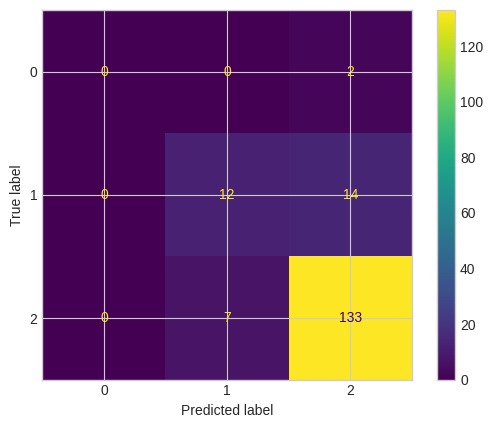

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

## **Pembeneran akurasi random forest**

In [ ]:

best_acc = -1
for i in range(1, 3000, 25):
  # Menentukan jumlah fitur terbaik yang ingin dipilih
  # Anda bisa bereksperimen dengan nilai k ini (misal, 500, 1000, 2000, dll.)
  k_best_features = i # Jumlah fitur yang akan dipilih

  # Menggunakan SelectKBest dengan fungsi skor chi2
  # chi2 cocok untuk data non-negatif (seperti TF-IDF) dan target kategorikal
  selector = SelectKBest(score_func=chi2, k=k_best_features)

  # Melakukan pemilihan fitur pada data training (X dan y)
  # Penting: fit hanya pada data training untuk menghindari data leakage
  # Namun, karena SelectKBest/chi2 adalah metode filter (tidak bergantung pada model),
  # kita bisa fit pada seluruh X dan y sebelum split, lalu transform X_train dan X_test
  # (atau fit dan transform X_train, lalu transform X_test).
  # Untuk konsistensi dengan alur, mari kita fit pada X dan y sebelum split.
  # Nanti setelah split, kita akan transform X_train dan X_test.

  # Pastikan X dan y sudah terdefinisi dari tahap TF-IDF dan konversi label
  try:
      X_new = selector.fit_transform(X, y)

      print(f"\nShape matriks fitur sebelum pemilihan fitur: {X.shape}")
      print(f"Shape matriks fitur setelah pemilihan fitur (memilih {k_best_features} fitur terbaik): {X_new.shape}")

      # Mendapatkan nama fitur yang dipilih (opsional, tapi informatif)
      # Dapatkan indeks fitur yang dipilih
      selected_feature_indices = selector.get_support(indices=True)

      # Dapatkan nama fitur asli dari TfidfVectorizer (perlu diakses dari objek tfidf)
      # Pastikan objek tfidf dari cell sebelumnya masih tersedia
      try:
          original_feature_names = tfidf.get_feature_names_out()
          selected_feature_names = [original_feature_names[i] for i in selected_feature_indices]
          print(f"\nBeberapa contoh fitur yang dipilih ({len(selected_feature_names)} fitur):")
          # Tampilkan beberapa fitur pertama dan terakhir
          display(selected_feature_names[:10] + selected_feature_names[-10:])

      except NameError:
          print("\nObjek 'tfidf' dari tahap TF-IDF tidak ditemukan.")
          print("Tidak dapat menampilkan nama fitur yang dipilih.")
      except Exception as e:
          print(f"\nTerjadi error saat mendapatkan nama fitur: {e}")


  except NameError:
      print("\nError: Variabel X atau y belum terdefinisi dari tahap sebelumnya.")
      print("Pastikan Anda telah menjalankan cell 'Tahap Ekstraksi Fitur'.")

  X_train, X_test, y_train, y_test = train_test_split(
      X_new, y,
      test_size=0.2,  # 25% data digunakan untuk testing
      random_state=42,  # Untuk reproduktifitas hasil
      # stratify=y  # Mempertahankan proporsi kelas sentimen pada data training dan testing
  )

  # rf = RandomForestClassifier(n_estimators=48, max_depth=80,min_samples_split=25,
  #                                min_samples_leaf=1,
  #                                class_weight='balanced', ccp_alpha=0)
  rf = RandomForestClassifier(min_samples_split=3, n_estimators=260)

  rf.fit(X_train, y_train)


  y_pred = rf.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  # print("Train Accuracy:", np.mean(y_train == rf.predict(X_train)))
  print(f"Accuracy: {accuracy}")
  if accuracy > best_acc:
    best_acc = accuracy
    k = i
print(f"Accuracybest: {best_acc}, k : {k}")


Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1 fitur terbaik): (2079, 1)

Beberapa contoh fitur yang dipilih (1 fitur):


['terrorist', 'terrorist']

Accuracy: 0.4567307692307692

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 26 fitur terbaik): (2079, 26)

Beberapa contoh fitur yang dipilih (26 fitur):


['arab',
 'attack',
 'best time',
 'blessed',
 'body',
 'brutally',
 'feeling',
 'force',
 'israeli',
 'karim',
 'palestinian gaza',
 'prison',
 'ramadan best',
 'syria',
 'terrorist',
 'time muslim',
 'tomorrow',
 'try',
 'weight',
 'wishing']

Accuracy: 0.7307692307692307

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 51 fitur terbaik): (2079, 51)

Beberapa contoh fitur yang dipilih (51 fitur):


['arab',
 'attack',
 'best time',
 'blessed',
 'blessed ramadan',
 'body',
 'broken',
 'brutally',
 'called',
 'christian',
 'suffering',
 'syria',
 'terrorist',
 'time muslim',
 'tired',
 'tomorrow',
 'try',
 'weight',
 'wishing',
 'year old']

Accuracy: 0.7740384615384616

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 76 fitur terbaik): (2079, 76)

Beberapa contoh fitur yang dipilih (76 fitur):


['arab',
 'attack',
 'best time',
 'blessed',
 'blessed peaceful',
 'blessed ramadan',
 'body',
 'broken',
 'brutally',
 'called',
 'tired',
 'tomorrow',
 'tonight',
 'try',
 'weight',
 'western',
 'wishing',
 'wishing blessed',
 'year old',
 'young']

Accuracy: 0.7980769230769231

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 101 fitur terbaik): (2079, 101)

Beberapa contoh fitur yang dipilih (101 fitur):


['allah',
 'arab',
 'attack',
 'beautiful',
 'best time',
 'blessed',
 'blessed peaceful',
 'blessed ramadan',
 'blessing',
 'body',
 'tonight',
 'try',
 'uk',
 'weight',
 'western',
 'wish',
 'wishing',
 'wishing blessed',
 'year old',
 'young']

Accuracy: 0.875

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 126 fitur terbaik): (2079, 126)

Beberapa contoh fitur yang dipilih (126 fitur):


['allah',
 'arab',
 'attack',
 'beautiful',
 'best',
 'best time',
 'blessed',
 'blessed peaceful',
 'blessed ramadan',
 'blessing',
 'western',
 'windsor',
 'windsor castle',
 'wish',
 'wishing',
 'wishing blessed',
 'woman',
 'world blessed',
 'year old',
 'young']

Accuracy: 0.8990384615384616

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 151 fitur terbaik): (2079, 151)

Beberapa contoh fitur yang dipilih (151 fitur):


['allah',
 'arab',
 'attack',
 'beautiful',
 'best',
 'best time',
 'bless',
 'blessed',
 'blessed month',
 'blessed peaceful',
 'western',
 'windsor',
 'windsor castle',
 'wish',
 'wishing',
 'wishing blessed',
 'woman',
 'world blessed',
 'year old',
 'young']

Accuracy: 0.9086538461538461

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 176 fitur terbaik): (2079, 176)

Beberapa contoh fitur yang dipilih (176 fitur):


['allah',
 'arab',
 'attack',
 'beautiful',
 'best',
 'best time',
 'bless',
 'blessed',
 'blessed month',
 'blessed peaceful',
 'wish',
 'wishing',
 'wishing blessed',
 'wishing muslim',
 'woman',
 'world',
 'world blessed',
 'worship',
 'year old',
 'young']

Accuracy: 0.9086538461538461

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 201 fitur terbaik): (2079, 201)

Beberapa contoh fitur yang dipilih (201 fitur):


['allah',
 'arab',
 'attack',
 'beautiful',
 'best',
 'best time',
 'bless',
 'blessed',
 'blessed month',
 'blessed peaceful',
 'wish',
 'wishing',
 'wishing blessed',
 'wishing muslim',
 'woman',
 'world',
 'world blessed',
 'worship',
 'year old',
 'young']

Accuracy: 0.9110576923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 226 fitur terbaik): (2079, 226)

Beberapa contoh fitur yang dipilih (226 fitur):


['activity',
 'allah',
 'allow',
 'arab',
 'attack',
 'beautiful',
 'best',
 'best time',
 'bless',
 'blessed',
 'wish',
 'wishing',
 'wishing blessed',
 'wishing muslim',
 'woman',
 'world',
 'world blessed',
 'worship',
 'year old',
 'young']

Accuracy: 0.9230769230769231

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 251 fitur terbaik): (2079, 251)

Beberapa contoh fitur yang dipilih (251 fitur):


['activity',
 'allah',
 'allow',
 'amazing',
 'arab',
 'attack',
 'beautiful',
 'best',
 'best time',
 'bless',
 'wishing muslim',
 'wishing observing',
 'woman',
 'wonderful',
 'work',
 'world',
 'world blessed',
 'worship',
 'year old',
 'young']

Accuracy: 0.9254807692307693

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 276 fitur terbaik): (2079, 276)

Beberapa contoh fitur yang dipilih (276 fitur):


['activity',
 'aid',
 'al',
 'allah',
 'allah accept',
 'allow',
 'amazing',
 'ameen',
 'arab',
 'attack',
 'wishing muslim',
 'wishing observing',
 'woman',
 'wonderful',
 'work',
 'world',
 'world blessed',
 'worship',
 'year old',
 'young']

Accuracy: 0.9302884615384616

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 301 fitur terbaik): (2079, 301)

Beberapa contoh fitur yang dipilih (301 fitur):


['activity',
 'aid',
 'al',
 'allah',
 'allah accept',
 'allow',
 'amazing',
 'ameen',
 'arab',
 'attack',
 'wishing muslim',
 'wishing observing',
 'woman',
 'wonderful',
 'work',
 'world',
 'world blessed',
 'worship',
 'year old',
 'young']

Accuracy: 0.9326923076923077

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 326 fitur terbaik): (2079, 326)

Beberapa contoh fitur yang dipilih (326 fitur):


['accept',
 'activity',
 'aid',
 'al',
 'allah',
 'allah accept',
 'allow',
 'amazing',
 'ameen',
 'arab',
 'wishing observing',
 'witness',
 'woman',
 'wonderful',
 'work',
 'world',
 'world blessed',
 'worship',
 'year old',
 'young']

Accuracy: 0.9375

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 351 fitur terbaik): (2079, 351)

Beberapa contoh fitur yang dipilih (351 fitur):


['accept',
 'activity',
 'aid',
 'al',
 'allah',
 'allah accept',
 'allow',
 'amazing',
 'ameen',
 'arab',
 'witness',
 'woman',
 'wonderful',
 'work',
 'world',
 'world blessed',
 'worship',
 'year old',
 'yes',
 'young']

Accuracy: 0.9375

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 376 fitur terbaik): (2079, 376)

Beberapa contoh fitur yang dipilih (376 fitur):


['accept',
 'activity',
 'aid',
 'al',
 'allah',
 'allah accept',
 'allow',
 'amazing',
 'ameen',
 'ankalaev',
 'witness',
 'woman',
 'wonderful',
 'work',
 'world',
 'world blessed',
 'worship',
 'year old',
 'yes',
 'young']

Accuracy: 0.9302884615384616

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 401 fitur terbaik): (2079, 401)

Beberapa contoh fitur yang dipilih (401 fitur):


['accept',
 'activity',
 'aid',
 'al',
 'allah',
 'allah accept',
 'allow',
 'amazing',
 'ameen',
 'ankalaev',
 'witness',
 'woman',
 'wonderful',
 'work',
 'world',
 'world blessed',
 'worship',
 'year old',
 'yes',
 'young']

Accuracy: 0.9326923076923077

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 426 fitur terbaik): (2079, 426)

Beberapa contoh fitur yang dipilih (426 fitur):


['accept',
 'action',
 'activity',
 'aid',
 'al',
 'alaqsamosque',
 'allah',
 'allah accept',
 'allow',
 'amazing',
 'witness',
 'woman',
 'wonderful',
 'work',
 'world',
 'world blessed',
 'worship',
 'year old',
 'yes',
 'young']

Accuracy: 0.9278846153846154

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 451 fitur terbaik): (2079, 451)

Beberapa contoh fitur yang dipilih (451 fitur):


['accept',
 'action',
 'activity',
 'aid',
 'al',
 'alaqsamosque',
 'allah',
 'allah accept',
 'allow',
 'amazing',
 'witness',
 'woman',
 'wonderful',
 'work',
 'world',
 'world blessed',
 'worship',
 'year old',
 'yes',
 'young']

Accuracy: 0.9326923076923077

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 476 fitur terbaik): (2079, 476)

Beberapa contoh fitur yang dipilih (476 fitur):


['accept',
 'action',
 'activity',
 'aid',
 'al',
 'alaqsamosque',
 'alex',
 'allah',
 'allah accept',
 'allow',
 'witness',
 'woman',
 'wonderful',
 'work',
 'world',
 'world blessed',
 'worship',
 'year old',
 'yes',
 'young']

Accuracy: 0.9399038461538461

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 501 fitur terbaik): (2079, 501)

Beberapa contoh fitur yang dipilih (501 fitur):


['accept',
 'action',
 'activity',
 'aid',
 'al',
 'alaqsamosque',
 'alex',
 'allah',
 'allah accept',
 'allow',
 'witness',
 'woman',
 'wonderful',
 'work',
 'world',
 'world blessed',
 'worship',
 'year old',
 'yes',
 'young']

Accuracy: 0.9399038461538461

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 526 fitur terbaik): (2079, 526)

Beberapa contoh fitur yang dipilih (526 fitur):


['abu',
 'accept',
 'act',
 'action',
 'activity',
 'aid',
 'al',
 'alaqsamosque',
 'alex',
 'allah',
 'witness',
 'woman',
 'wonderful',
 'work',
 'world',
 'world blessed',
 'worship',
 'year old',
 'yes',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 551 fitur terbaik): (2079, 551)

Beberapa contoh fitur yang dipilih (551 fitur):


['abu',
 'accept',
 'act',
 'action',
 'activity',
 'aid',
 'al',
 'alaqsamosque',
 'alex',
 'allah',
 'witness',
 'woman',
 'wonderful',
 'work',
 'world',
 'world blessed',
 'worship',
 'year old',
 'yes',
 'young']

Accuracy: 0.9350961538461539

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 576 fitur terbaik): (2079, 576)

Beberapa contoh fitur yang dipilih (576 fitur):


['abu',
 'accept',
 'act',
 'action',
 'activity',
 'aid',
 'al',
 'alaqsamosque',
 'alex',
 'allah',
 'witness',
 'woman',
 'wonderful',
 'work',
 'world',
 'world blessed',
 'worship',
 'year old',
 'yes',
 'young']

Accuracy: 0.9350961538461539

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 601 fitur terbaik): (2079, 601)

Beberapa contoh fitur yang dipilih (601 fitur):


['abu',
 'accept',
 'act',
 'action',
 'activity',
 'aid',
 'al',
 'alaqsamosque',
 'alex',
 'allah',
 'witness',
 'woman',
 'wonderful',
 'work',
 'world',
 'world blessed',
 'worship',
 'year old',
 'yes',
 'young']

Accuracy: 0.9399038461538461

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 626 fitur terbaik): (2079, 626)

Beberapa contoh fitur yang dipilih (626 fitur):


['abu',
 'accept',
 'act',
 'action',
 'activity',
 'admin',
 'admin post',
 'aid',
 'al',
 'alaqsamosque',
 'witness',
 'woman',
 'wonderful',
 'work',
 'world',
 'world blessed',
 'worship',
 'year old',
 'yes',
 'young']

Accuracy: 0.9471153846153846

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 651 fitur terbaik): (2079, 651)

Beberapa contoh fitur yang dipilih (651 fitur):


['abu',
 'accept',
 'act',
 'action',
 'activity',
 'admin',
 'admin post',
 'ahead',
 'aid',
 'al',
 'witness',
 'woman',
 'wonderful',
 'work',
 'world',
 'world blessed',
 'worship',
 'year old',
 'yes',
 'young']

Accuracy: 0.9375

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 676 fitur terbaik): (2079, 676)

Beberapa contoh fitur yang dipilih (676 fitur):


['abu',
 'accept',
 'act',
 'action',
 'activity',
 'admin',
 'admin post',
 'ahead',
 'aid',
 'al',
 'woman',
 'wonderful',
 'word',
 'work',
 'world',
 'world blessed',
 'worship',
 'year old',
 'yes',
 'young']

Accuracy: 0.9399038461538461

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 701 fitur terbaik): (2079, 701)

Beberapa contoh fitur yang dipilih (701 fitur):


['abu',
 'accept',
 'according',
 'act',
 'action',
 'activity',
 'admin',
 'admin post',
 'ahead',
 'aid',
 'woman',
 'wonderful',
 'word',
 'work',
 'world',
 'world blessed',
 'worship',
 'year old',
 'yes',
 'young']

Accuracy: 0.9471153846153846

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 726 fitur terbaik): (2079, 726)

Beberapa contoh fitur yang dipilih (726 fitur):


['abu',
 'accept',
 'accepted',
 'according',
 'act',
 'action',
 'activist',
 'activity',
 'admin',
 'admin post',
 'woman',
 'wonderful',
 'word',
 'work',
 'world',
 'world blessed',
 'worship',
 'year old',
 'yes',
 'young']

Accuracy: 0.9471153846153846

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 751 fitur terbaik): (2079, 751)

Beberapa contoh fitur yang dipilih (751 fitur):


['abu',
 'accept',
 'accepted',
 'according',
 'act',
 'action',
 'activist',
 'activity',
 'additionally',
 'admin',
 'woman',
 'wonderful',
 'word',
 'work',
 'world',
 'world blessed',
 'worship',
 'year old',
 'yes',
 'young']

Accuracy: 0.9471153846153846

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 776 fitur terbaik): (2079, 776)

Beberapa contoh fitur yang dipilih (776 fitur):


['abu',
 'accept',
 'accepted',
 'according',
 'act',
 'action',
 'activist',
 'activity',
 'additionally',
 'admin',
 'wonderful',
 'word',
 'work',
 'world',
 'world blessed',
 'worship',
 'year old',
 'yes',
 'york',
 'young']

Accuracy: 0.9471153846153846

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 801 fitur terbaik): (2079, 801)

Beberapa contoh fitur yang dipilih (801 fitur):


['abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'action',
 'activist',
 'activity',
 'additionally',
 'wonderful',
 'word',
 'work',
 'world',
 'world blessed',
 'worship',
 'year old',
 'yes',
 'york',
 'young']

Accuracy: 0.9447115384615384

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 826 fitur terbaik): (2079, 826)

Beberapa contoh fitur yang dipilih (826 fitur):


['abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'action',
 'activist',
 'activity',
 'additionally',
 'world',
 'world blessed',
 'worship',
 'ya',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 851 fitur terbaik): (2079, 851)

Beberapa contoh fitur yang dipilih (851 fitur):


['abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'action',
 'activist',
 'activity',
 'additionally',
 'world',
 'world blessed',
 'worship',
 'ya',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9471153846153846

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 876 fitur terbaik): (2079, 876)

Beberapa contoh fitur yang dipilih (876 fitur):


['abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'action',
 'activist',
 'activity',
 'additionally',
 'world',
 'world blessed',
 'worship',
 'ya',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9447115384615384

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 901 fitur terbaik): (2079, 901)

Beberapa contoh fitur yang dipilih (901 fitur):


['abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'action',
 'activist',
 'activity',
 'additionally',
 'world',
 'world blessed',
 'worship',
 'ya',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 926 fitur terbaik): (2079, 926)

Beberapa contoh fitur yang dipilih (926 fitur):


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'action',
 'activist',
 'activity',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9375

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 951 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=951 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9399038461538461

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 976 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=976 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9447115384615384

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1001 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1001 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9399038461538461

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1026 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1026 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9447115384615384

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1051 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1051 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9375

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1076 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1076 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9471153846153846

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1101 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1101 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9350961538461539

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1126 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1126 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9399038461538461

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1151 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1151 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9495192307692307

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1176 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1176 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9399038461538461

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1201 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1201 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9375

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1226 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1226 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9447115384615384

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1251 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1251 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9399038461538461

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1276 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1276 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9375

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1301 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1301 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1326 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1326 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1351 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1351 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1376 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1376 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1401 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1401 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9375

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1426 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1426 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1451 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1451 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9471153846153846

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1476 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1476 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1501 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1501 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1526 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1526 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1551 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1551 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9447115384615384

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1576 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1576 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9495192307692307

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1601 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1601 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9447115384615384

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1626 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1626 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9471153846153846

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1651 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1651 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9447115384615384

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1676 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1676 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9375

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1701 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1701 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1726 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1726 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9399038461538461

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1751 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1751 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9399038461538461

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1776 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1776 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1801 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1801 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9471153846153846

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1826 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1826 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9375

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1851 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1851 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9375

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1876 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1876 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9399038461538461

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1901 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1901 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9375

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1926 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1926 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1951 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1951 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9447115384615384

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1976 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1976 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9447115384615384

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2001 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2001 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9399038461538461

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2026 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2026 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9447115384615384

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2051 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2051 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9447115384615384

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2076 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2076 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2101 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2101 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2126 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2126 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9447115384615384

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2151 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2151 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2176 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2176 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2201 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2201 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9375

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2226 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2226 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9447115384615384

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2251 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2251 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9495192307692307

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2276 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2276 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9471153846153846

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2301 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2301 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9495192307692307

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2326 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2326 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2351 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2351 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9399038461538461

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2376 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2376 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9471153846153846

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2401 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2401 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9399038461538461

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2426 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2426 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9447115384615384

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2451 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2451 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2476 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2476 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9399038461538461

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2501 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2501 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9447115384615384

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2526 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2526 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9399038461538461

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2551 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2551 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9375

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2576 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2576 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9471153846153846

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2601 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2601 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9471153846153846

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2626 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2626 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9399038461538461

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2651 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2651 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2676 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2676 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9447115384615384

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2701 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2701 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9399038461538461

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2726 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2726 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2751 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2751 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9399038461538461

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2776 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2776 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9447115384615384

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2801 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2801 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2826 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2826 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2851 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2851 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2876 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2876 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2901 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2901 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9447115384615384

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2926 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2926 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9399038461538461

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2951 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2951 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9471153846153846

Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 2976 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=2976 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9423076923076923
Accuracybest: 0.9495192307692307, k : 1151


In [ ]:
rf

RandomForestClassifier(ccp_alpha=0, class_weight='balanced', max_depth=80,
                       min_samples_split=25, n_estimators=48)

In [ ]:
# Menentukan jumlah fitur terbaik yang ingin dipilih
# Anda bisa bereksperimen dengan nilai k ini (misal, 500, 1000, 2000, dll.)
k_best_features = 1151 # Jumlah fitur yang akan dipilih

# Menggunakan SelectKBest dengan fungsi skor chi2
# chi2 cocok untuk data non-negatif (seperti TF-IDF) dan target kategorikal
selector = SelectKBest(score_func=chi2, k=k_best_features)

# Melakukan pemilihan fitur pada data training (X dan y)
# Penting: fit hanya pada data training untuk menghindari data leakage
# Namun, karena SelectKBest/chi2 adalah metode filter (tidak bergantung pada model),
# kita bisa fit pada seluruh X dan y sebelum split, lalu transform X_train dan X_test
# (atau fit dan transform X_train, lalu transform X_test).
# Untuk konsistensi dengan alur, mari kita fit pada X dan y sebelum split.
# Nanti setelah split, kita akan transform X_train dan X_test.

# Pastikan X dan y sudah terdefinisi dari tahap TF-IDF dan konversi label
try:
    X_new = selector.fit_transform(X, y)

    print(f"\nShape matriks fitur sebelum pemilihan fitur: {X.shape}")
    print(f"Shape matriks fitur setelah pemilihan fitur (memilih {k_best_features} fitur terbaik): {X_new.shape}")

    # Mendapatkan nama fitur yang dipilih (opsional, tapi informatif)
    # Dapatkan indeks fitur yang dipilih
    selected_feature_indices = selector.get_support(indices=True)

    # Dapatkan nama fitur asli dari TfidfVectorizer (perlu diakses dari objek tfidf)
    # Pastikan objek tfidf dari cell sebelumnya masih tersedia
    try:
        original_feature_names = tfidf.get_feature_names_out()
        selected_feature_names = [original_feature_names[i] for i in selected_feature_indices]
        print(f"\nBeberapa contoh fitur yang dipilih ({len(selected_feature_names)} fitur):")
        # Tampilkan beberapa fitur pertama dan terakhir
        display(selected_feature_names[:10] + selected_feature_names[-10:])

    except NameError:
        print("\nObjek 'tfidf' dari tahap TF-IDF tidak ditemukan.")
        print("Tidak dapat menampilkan nama fitur yang dipilih.")
    except Exception as e:
        print(f"\nTerjadi error saat mendapatkan nama fitur: {e}")


except NameError:
    print("\nError: Variabel X atau y belum terdefinisi dari tahap sebelumnya.")
    print("Pastikan Anda telah menjalankan cell 'Tahap Ekstraksi Fitur'.")

# smote=SMOTE(sampling_strategy='auto')
# X_new,y=smote.fit_resample(X_new,y)
# from imblearn.under_sampling import RandomUnderSampler

# undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=42)
# X, y = undersampler.fit_resample(X, y)
# Sekarang, variabel fitur yang akan digunakan untuk split data adalah X_new
# Tahap selanjutnya (Pembagian Data) harus menggunakan X_new dan y

X_train, X_test, y_train, y_test = train_test_split(
    X_new, y,
    test_size=0.2,  # 25% data digunakan untuk testing
    random_state=42,  # Untuk reproduktifitas hasil
    # stratify=y  # Mempertahankan proporsi kelas sentimen pada data training dan testing
)

rf = RandomForestClassifier(n_estimators=48, max_depth=None,min_samples_split=25,
                                 min_samples_leaf=1,
                                 class_weight='balanced', ccp_alpha=0)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
# print("Train Accuracy:", np.mean(y_train == rf.predict(X_train)))
print(f"Accuracy: {accuracy}")



Shape matriks fitur sebelum pemilihan fitur: (2079, 937)
Shape matriks fitur setelah pemilihan fitur (memilih 1151 fitur terbaik): (2079, 937)

Beberapa contoh fitur yang dipilih (937 fitur):


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=1151 is greater than n_features=937. All the features will be returned.
  warnings.warn(


['able',
 'abu',
 'accept',
 'accepted',
 'according',
 'account',
 'act',
 'act worship',
 'action',
 'activist',
 'world blessed',
 'worship',
 'ya',
 'ya allah',
 'year',
 'year old',
 'yes',
 'yesterday',
 'york',
 'young']

Accuracy: 0.9375


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_new, y,
    test_size=0.2,  # 25% data digunakan untuk testing
    random_state=42,  # Untuk reproduktifitas hasil
    # stratify=y  # Mempertahankan proporsi kelas sentimen pada data training dan testing
)

In [ ]:

rf = RandomForestClassifier(criterion= 'entropy',
    max_depth= 80,
    min_samples_split= 25,
    min_samples_leaf= 1,
    class_weight= 'balanced',
    ccp_alpha= 0.0 )
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Train Accuracy:", np.mean(y_train == rf.predict(X_train)))
print(f"Testing Accuracy: {accuracy}")


Train Accuracy: 0.9831629585087192
Testing Accuracy: 0.9350961538461539


In [ ]:
|rf

RandomForestClassifier()

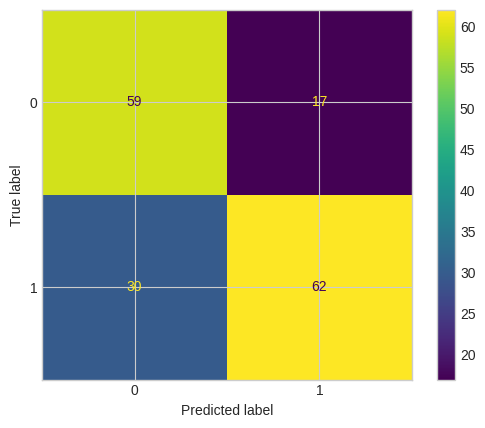

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [ ]:
# rf = RandomForestClassifier(n_estimators=1000, min_samples_leaf=1, min_samples_split=20, max_depth=None)
rf = RandomForestClassifier(min_samples_split=3, n_estimators=260)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Train Accuracy:", np.mean(y_train == rf.predict(X_train)))
print(f"Accuracy: {accuracy}")


Train Accuracy: 0.9939867708959711
Accuracy: 0.9447115384615384


In [ ]:
# best_model.get_params()

In [ ]:
# rf.get_params()

In [ ]:
rf_grid = RandomForestClassifier(n_estimators=260, max_depth=None)
gr_space = {
    # 'max_depth': [3,5,7,10],
    # 'n_estimators': [100, 200, 300, 400, 500],
    # 'max_features': [10, 20, 30 , 40],
    # 'min_samples_leaf': [1, 2, 4]
    # 'max_depth': [2, 3, 5, 10, 20, 25],
    # 'min_samples_leaf': [2, 5, 10, 20, 50, 100],
    'criterion': ['entropy'],
    'min_samples_split': list(range(2, 21)),
    'min_samples_leaf': [1, 2, 3, 4,5, 6,7, 8],    # Perluas sedikit
}

grid = GridSearchCV(rf_grid, gr_space, cv = 3, scoring='accuracy', verbose = 3)
model_grid = grid.fit(X_train, y_train)
# Create a variable for the best model
best_rf = model_grid.best_estimator_
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print('Best hyperparameters are '+str(model_grid.best_params_))
print('Best score is: ' + str(model_grid.best_score_))

print("\nTrain Accuracy:", np.mean(y_train == best_rf.predict(X_train)))
print("Test Accuracy:", accuracy)

Fitting 3 folds for each of 152 candidates, totalling 456 fits
[CV 1/3] END criterion=entropy, min_samples_leaf=1, min_samples_split=2;, score=0.870 total time=   1.1s
[CV 2/3] END criterion=entropy, min_samples_leaf=1, min_samples_split=2;, score=0.865 total time=   1.1s
[CV 3/3] END criterion=entropy, min_samples_leaf=1, min_samples_split=2;, score=0.874 total time=   1.0s
[CV 1/3] END criterion=entropy, min_samples_leaf=1, min_samples_split=3;, score=0.870 total time=   0.9s
[CV 2/3] END criterion=entropy, min_samples_leaf=1, min_samples_split=3;, score=0.861 total time=   0.7s
[CV 3/3] END criterion=entropy, min_samples_leaf=1, min_samples_split=3;, score=0.874 total time=   0.8s
[CV 1/3] END criterion=entropy, min_samples_leaf=1, min_samples_split=4;, score=0.879 total time=   1.1s
[CV 2/3] END criterion=entropy, min_samples_leaf=1, min_samples_split=4;, score=0.874 total time=   1.1s
[CV 3/3] END criterion=entropy, min_samples_leaf=1, min_samples_split=4;, score=0.869 total time=

In [ ]:
# param_dist = {
#     'n_estimators': randint(50,500),
#     'max_depth': randint(1,20),

#               'min_samples_leaf': randint(1, 4),
#               'min_samples_split': randint(2, 30),
#               # 'max_features': ['auto', 'sqrt', 'log2'],
#               # 'criterion': ['gini', 'entropy']
#     }

n_estimators = [5,20,50,100] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [2, 6, 10] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=100,
                                 cv=5,
                                 n_jobs=-1,
                                 verbose=2,
                                #  scoring='accuracy'
                                 )

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e1bfa1efa90>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e1bfa1b6d10>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e1bfa049150>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e1bfa0c0850>},
                   verbose=2)

In [ ]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

print("Train Accuracy:", np.mean(y_train == best_rf.predict(X_train)))
print("Test Accuracy:", accuracy)

Best hyperparameters: {'max_depth': 19, 'min_samples_leaf': 2, 'min_samples_split': 17, 'n_estimators': 260}
Train Accuracy: 0.907185628742515
Test Accuracy: 0.8571428571428571


In [ ]:
# INI BIAR GA KEHAPUS BEST ACC
param_dist = {
    'n_estimators': randint(50,500),
    # 'max_depth': randint(1,20),

              # 'min_samples_leaf': randint(1, 4),
              # 'min_samples_split': randint(2, 30),
              # 'max_features': ['auto', 'sqrt', 'log2'],
              # 'criterion': ['gini', 'entropy']
    }

# Create a random forest classifier
rf = RandomForestClassifier(n_estimators=48, max_depth=None,min_samples_split=25,
                                 min_samples_leaf=1,
                                 class_weight='balanced', ccp_alpha=0)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=10,
                                 cv=5,
                                 n_jobs=-1,
                                 verbose=5,
                                #  scoring='accuracy'
                                 )

# Fit the random search object to the data
rand_search.fit(X_train, y_train)
# Create a variable for the best model
best_rf = rand_search.best_estimator_

y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

print("Train Accuracy:", np.mean(y_train == best_rf.predict(X_train)))
print("Test Accuracy:", accuracy)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters: {'n_estimators': 393}
Train Accuracy: 0.9312762973352033
Test Accuracy: 0.8547486033519553


In [ ]:
# Yang kelas 3
# INI BIAR GA KEHAPUS BEST ACC
param_dist = {
    'n_estimators': randint(50,500),
    # 'max_depth': randint(1,20),

              # 'min_samples_leaf': randint(1, 4),
              # 'min_samples_split': randint(2, 30),
              # 'max_features': ['auto', 'sqrt', 'log2'],
              # 'criterion': ['gini', 'entropy']
    }

# Create a random forest classifier
rf = RandomForestClassifier(n_estimators=48, max_depth=None,min_samples_split=25,
                                 min_samples_leaf=1,
                                 class_weight='balanced', ccp_alpha=0)

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=10,
                                 cv=5,
                                 n_jobs=-1,
                                 verbose=5,
                                #  scoring='accuracy'
                                 )

# Fit the random search object to the data
rand_search.fit(X_train, y_train)
# Create a variable for the best model
best_rf = rand_search.best_estimator_

y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

print("Train Accuracy:", np.mean(y_train == best_rf.predict(X_train)))
print("Test Accuracy:", accuracy)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters: {'n_estimators': 433}
Train Accuracy: 0.9730538922155688
Test Accuracy: 0.8333333333333334


In [ ]:
Test Accuracy: 0.8392857142857143

In [ ]:
best_model = None
best_acc = -1

# max_depth= [2, 3, 5, 10, 20, 25]
min_samples_leaf_ar= [1, 2, 3, 4,5, 6,7, 8]    # Perluas sedikit
min_samples_split_ar = list(range(2, 21))
# ccp_alpha_ar = [0.0, 0.001, 0.005, 0.01]
# criterion = ['gini', 'entropy', 'log_loss']
# splitter = ['best', 'random']
# min_weight_fraction_leaf = [0.0, 0.01, 0.05]
# max_features = [None, 'sqrt', 'log2']
# max_leaf_nodes = [None, 10, 20, 50, 100]
# min_impurity_decrease = [0.0, 0.01, 0.1]
# class_weight = [None, 'balanced']

# for max_depth in max_depth:
for min_samples_leaf in min_samples_leaf_ar:
  for min_samples_split in min_samples_split_ar:
    # for ccp_alpha in ccp_alpha_ar:
    for i in range(5):

      # print(f"\nmax_depth : {max_depth}")
      print(f"\nmin_samples_leaf : {min_samples_leaf}")
      print(f"min_samples_split : {min_samples_split}")
      # print(f"ccp : {ccp_alpha}")
      # Create the Decision Tree model with given parameters
      model = RandomForestClassifier(n_estimators=260,
                                      max_depth=None,
                                      min_samples_leaf=min_samples_leaf,
                                      min_samples_split=min_samples_split)

      # Train the model
      model.fit(X_train, y_train)

      # Predict on the test set
      y_pred = model.predict(X_test)

      # Calculate accuracy
      # Predictions
      train_preds = model.predict(X_train)
      test_preds = model.predict(X_test)

      # Accuracy scores
      train_accuracy = accuracy_score(y_train, train_preds)
      test_accuracy = accuracy_score(y_test, test_preds)

      print("Training Accuracy:", train_accuracy)
      print("Test Accuracy:", test_accuracy)
      if test_accuracy > best_acc:
        best_model = model
        best_acc = test_accuracy
train_accuracy = accuracy_score(y_train, best_model.predict(X_train))
print("\n\nTraining Accuracy:", train_accuracy)
print(f"Akurasi plg bagus : {best_acc}")
# Play beep in browser (via JS)
from IPython.display import Audio, display

def beep():
    display(Audio(url="https://actions.google.com/sounds/v1/alarms/beep_short.ogg", autoplay=True))
for i in range(1000):
  beep()


min_samples_leaf : 1
min_samples_split : 2
Training Accuracy: 0.9939867708959711
Test Accuracy: 0.9423076923076923

min_samples_leaf : 1
min_samples_split : 2
Training Accuracy: 0.9939867708959711
Test Accuracy: 0.9399038461538461

min_samples_leaf : 1
min_samples_split : 2
Training Accuracy: 0.9939867708959711
Test Accuracy: 0.9399038461538461

min_samples_leaf : 1
min_samples_split : 2
Training Accuracy: 0.9939867708959711
Test Accuracy: 0.9423076923076923

min_samples_leaf : 1
min_samples_split : 2
Training Accuracy: 0.9939867708959711
Test Accuracy: 0.9423076923076923

min_samples_leaf : 1
min_samples_split : 3
Training Accuracy: 0.9939867708959711
Test Accuracy: 0.9423076923076923

min_samples_leaf : 1
min_samples_split : 3
Training Accuracy: 0.9939867708959711
Test Accuracy: 0.9447115384615384

min_samples_leaf : 1
min_samples_split : 3
Training Accuracy: 0.9939867708959711
Test Accuracy: 0.9471153846153846

min_samples_leaf : 1
min_samples_split : 3
Training Accuracy: 0.9939867

In [ ]:
best_model

RandomForestClassifier(min_samples_split=3, n_estimators=260)

In [ ]:

RandomForestClassifier(min_samples_split=3, n_estimators=260)
Akurasi plg bagus : 0.9471153846153846

RandomForestClassifier(min_samples_split=9, n_estimators=260)
Training Accuracy: 0.9745508982035929
Akurasi plg bagus : 0.8869047619047619

In [ ]:
"""
0.2 351 k
Best hyperparameters: {'min_samples_leaf': 1, 'min_samples_split': 13, 'n_estimators': 414} dan max depth none
Train Accuracy: 0.9431137724550899
Test Accuracy: 0.8511904761904762

0.2 101 k
Best hyperparameters: {'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 225} dan max depth none
Train Accuracy: 0.8473053892215568
Test Accuracy: 0.8392857142857143

0.3 split 2000 k
Training Accuracy: 0.9641025641025641
Akurasi plg bagus : 0.8446215139442231
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 9,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 48,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

0.3 split
Training Accuracy: 0.9623931623931624
Akurasi plg bagus : 0.8366533864541833
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 9,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 48,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

train : 0.9145299145299145
Akurasi plg bagus : 0.8326693227091634
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 48,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Training Accuracy: 0.8786324786324786
Akurasi plg bagus : 0.8286852589641435
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 40,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 9,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 48,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

30
Akurasi plg bagus : 0.8167330677290837

train : 0.9145299145299145
Akurasi plg bagus : 0.8326693227091634
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 12,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 48,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

max  depth 40
Akurasi plg bagus : 0.8214285714285714

max depth :35
Akurasi plg bagus : 0.8273809523809523

max depth :35
Akurasi plg bagus : 0.8214285714285714
"""

SyntaxError: incomplete input (<ipython-input-187-969763094>, line 1)

In [ ]:
best_model = None
best_acc = -1
for i in range(25):
  model = best_rf
  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)

  print(i, end=', ')
  print("Train Accuracy:", np.mean(y_train == best_rf.predict(X_train)), end=', ')
  print("Test Accuracy:", accuracy)

  if accuracy > best_acc:
    best_model = model
    best_acc = accuracy
print(f"Best acc is : {best_acc}")
print('Best hyperparameters:',  best_model.get_params())

0, Train Accuracy: 0.8488023952095808, Test Accuracy: 0.7202380952380952
1, Train Accuracy: 0.8502994011976048, Test Accuracy: 0.7083333333333334
2, Train Accuracy: 0.8458083832335329, Test Accuracy: 0.7202380952380952
3, Train Accuracy: 0.8383233532934131, Test Accuracy: 0.7380952380952381
4, Train Accuracy: 0.842814371257485, Test Accuracy: 0.7380952380952381
5, Train Accuracy: 0.8413173652694611, Test Accuracy: 0.7440476190476191
6, Train Accuracy: 0.842814371257485, Test Accuracy: 0.7261904761904762
7, Train Accuracy: 0.8502994011976048, Test Accuracy: 0.7083333333333334
8, Train Accuracy: 0.8502994011976048, Test Accuracy: 0.7440476190476191
9, Train Accuracy: 0.8488023952095808, Test Accuracy: 0.7142857142857143
10, Train Accuracy: 0.8502994011976048, Test Accuracy: 0.7142857142857143
11, Train Accuracy: 0.8517964071856288, Test Accuracy: 0.7440476190476191
12, Train Accuracy: 0.8458083832335329, Test Accuracy: 0.7321428571428571
13, Train Accuracy: 0.8458083832335329, Test Accur

In [ ]:
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(i, end=', ')
print("Train Accuracy:", np.mean(y_train == best_rf.predict(X_train)), end=', ')
print("Test Accuracy:", accuracy)

24, Train Accuracy: 0.8368263473053892, Test Accuracy: 0.7440476190476191


In [ ]:
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Train Accuracy:", np.mean(y_train == best_rf.predict(X_train)))
print("Test Accuracy:", accuracy)

Train Accuracy: 0.8622754491017964
Test Accuracy: 0.7142857142857143


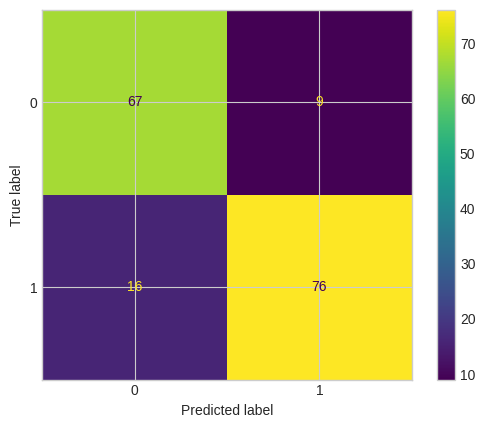

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

## **Neural Network**

In [ ]:
# transform = transforms.Compose([
#     transforms.ToTensor()  # Convert to PyTorch tensor
# ])

tensor_x = torch.from_numpy(X_train.astype('float32').todense())
tensor_y = torch.Tensor(y_train)

tensor_x_test = torch.Tensor(X_test.astype('float32').todense()) # transform to torch tensor
tensor_y_test = torch.Tensor(y_test.to_numpy())

train_dataset = TensorDataset(tensor_x,tensor_y)
test_dataset = TensorDataset(tensor_x_test,tensor_y_test)

loader_train = DataLoader(train_dataset, batch_size=10, shuffle=False)
loader_test = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
y_train

,sentiment
1628,1
1499,0
743,2
1829,1
637,2
...,...
1638,1
1095,0
1130,0
1294,0


In [ ]:
lr = 10**random.uniform(2,-6)

In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim, classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 500)
        self.fc2 = nn.Linear(500, classes)
        # self.fc3 = nn.Linear(100, 30)
        # self.fc4 = nn.Linear(30, 30)
        # self.fc5 = nn.Linear(30, classes)
        # self.fc5 = nn.Linear(84, classes)

    def forward(self, x):
        x = x.float()
        # x = F.sigmoid(self.fc1(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # x = F.relu(self.fc3(x))
        # x = F.relu(self.fc4(x))
        # x = self.fc5(x)

        # x = self.fc1(x)


        # x = F.relu(self.fc2(x))
        # x = self.fc(x)
        return x




In [ ]:
criterion = nn.CrossEntropyLoss()
for j in range(1):
  net = Net(937, 3)

  # print(f"lr : {lr}")
  optimizer = optim.Adam(net.parameters(), lr=1.584618639910894e-05) # 1.584618639910894e-05
  for epoch in range(50):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(loader_train, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          labels = labels.long()
          # print(inputs.dtype)
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 64 == 500:    # print every 2000 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              running_loss = 0.0

      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in loader_test:
          images, labels = data
          # calculate outputs by running images through the network
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'Accuracy of the network: {100 * correct // total} %')

  print('Finished Training')

[1,   167] loss: 0.091
[2,   167] loss: 0.091
[3,   167] loss: 0.090
[4,   167] loss: 0.089
[5,   167] loss: 0.088
[6,   167] loss: 0.087
[7,   167] loss: 0.086
[8,   167] loss: 0.084
[9,   167] loss: 0.082
[10,   167] loss: 0.080
[11,   167] loss: 0.078


KeyboardInterrupt: 

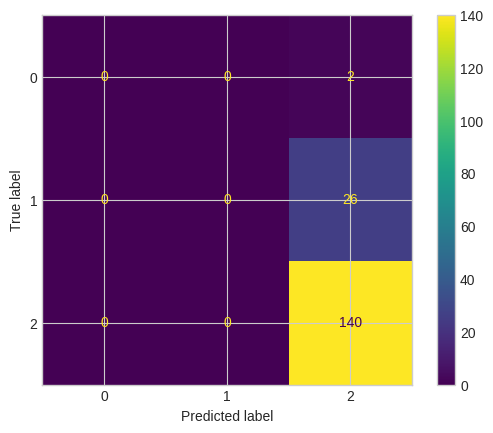

In [ ]:
y_pred = np.array([])
with torch.no_grad():
      for data in loader_test:

          images, labels = data
          # calculate outputs by running images through the network
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)

          y_pred = np.concatenate((y_pred, predicted.numpy()))

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

## **Neural Network dengan perbaikan akurasi**

## **Course search**

In [ ]:
from IPython.display import Audio, display

def beep():
    display(Audio(url="https://actions.google.com/sounds/v1/alarms/beep_short.ogg", autoplay=True))


for j in range(100):
  net = Net(937, 3)
  lr = 10**random.uniform(2,-6)
  reg = 10**random.uniform(-5,5)

  optimizer = optim.Adam(net.parameters(), lr=lr,weight_decay=reg) # 1.584618639910894e-05
  for epoch in range(5):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(loader_train, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          labels = labels.long()
          # print(inputs.dtype)
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 64 == 500:    # print every 2000 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              running_loss = 0.0
  print(f"lr : {lr}, reg : {reg}", end=', ')
      # print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
  # correct = 0
  # total = 0
  # with torch.no_grad():
  #     for data in loader_train:
  #         images, labels = data
  #         # calculate outputs by running images through the network
  #         outputs = net(images)
  #         # the class with the highest energy is what we choose as prediction
  #         _, predicted = torch.max(outputs.data, 1)
  #         total += labels.size(0)
  #         correct += (predicted == labels).sum().item()
  # print(f'Accuracy training: {100 * correct // total} %')
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in loader_test:
          images, labels = data
          # calculate outputs by running images through the network
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()



  print(f'Accuracy testing: {100 * correct // total} %')

  # print('Finished Training')

lr : 2.432355268009338e-05, reg : 64.55157471460004, Accuracy testing: 32 %
lr : 0.438036155384411, reg : 2.2935077936715613, Accuracy testing: 31 %
lr : 1.508866133766971e-05, reg : 2.5171947361490923, Accuracy testing: 35 %
lr : 0.00022731433053535993, reg : 0.8281060914076787, Accuracy testing: 31 %


KeyboardInterrupt: 

In [ ]:
for i in range(1000):
  beep()

## **Finer search**

In [ ]:
best_model = None
best_acc = -1
for j in range(100):
  net = Net(937, 3)
  lr = 10**random.uniform(-1,-3)
  reg = 10**random.uniform(-5,-5)
  print(f"lr : {lr}, reg : {reg}", end=', ')

  optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=reg) # 1.584618639910894e-05
  for epoch in range(10):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(loader_train, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          labels = labels.long()
          # print(inputs.dtype)
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 64 == 500:    # print every 2000 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              running_loss = 0.0
      correct = 0
      total = 0
      # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in loader_test:
          images, labels = data
          # calculate outputs by running images through the network
          outputs = net(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  print(f'Accuracy testing: {100 * correct // total} %')
  acc = 100 * correct // total
  if acc > best_acc:
    best_model = net
    best_acc = acc


      # print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
  # correct = 0
  # total = 0
  # with torch.no_grad():
  #     for data in loader_train:
  #         images, labels = data
  #         # calculate outputs by running images through the network
  #         outputs = net(images)
  #         # the class with the highest energy is what we choose as prediction
  #         _, predicted = torch.max(outputs.data, 1)
  #         total += labels.size(0)
  #         correct += (predicted == labels).sum().item()
  # print(f'Accuracy training: {100 * correct // total} %')






print('Finished Training')
print(f"Best acc : {best_acc}")

lr : 0.0022556293761310325, reg : 1e-05, Accuracy testing: 88 %
lr : 0.010436191453794649, reg : 1e-05, 

KeyboardInterrupt: 

In [ ]:
class Net(nn.Module):
    def __init__(self, input_dim, classes):
        super().__init__()

        self.fc1 = nn.Linear(input_dim, 700)
        torch.nn.init.xavier_uniform_(self.fc1.weight)

        self.fc2 = nn.Linear(700, classes)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        # self.fc3 = nn.Linear(100, 30)
        # self.fc4 = nn.Linear(30, 30)
        # self.fc5 = nn.Linear(30, classes)
        # self.fc5 = nn.Linear(84, classes)

    def forward(self, x):
        x = x.float()
        # x = F.sigmoid(self.fc1(x))
        x = F.relu((self.fc1(x)))
        x = self.fc2(x)
        # x = F.relu(self.fc3(x))
        # x = F.relu(self.fc4(x))
        # x = self.fc5(x)

        # x = self.fc1(x)


        # x = F.relu(self.fc2(x))
        # x = self.fc(x)
        return x




In [ ]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.MultiMarginLoss()

In [ ]:
loss_list = []
test_list = []
train_list = []
l1_ar = [2, 4, 8, 16, 32, 64, 128, 256, 512]

# for l1 in [512]:
for j in range(1):
  net = Net(937, 3)
  # lr = 0.00012760422205143742
  # lr = 0.00013022156954668927
  # lr =0.0002013597445353245
  # lr = 0.00014926566021498933
  # lr = 0.00013523158305498746
  lr = 0.0015666022369767846
  reg : 8.001732159058187e-05
  # print(f"=={l2}=="), reg :
  optimizer = optim.Adam(net.parameters(), lr=0.12118440570554175, weight_decay=3.189733502609255e-050) # 1.584618639910894e-05
  for epoch in range(30):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(loader_train, 0):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          labels = labels.long()
          # print(inputs.dtype)
          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          # print statistics
          running_loss += loss.item()
          if i % 64 == 500:    # print every 2000 mini-batches
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              running_loss = 0.0
      loss_list.append((running_loss / 2000))
      # print(f"lr : {lr}", end=', ')
      print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')

      correct = 0
      total = 0
      with torch.no_grad():
          for data in loader_train:
              images, labels = data
              # calculate outputs by running images through the network
              outputs = net(images)
              # the class with the highest energy is what we choose as prediction
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
      print(f'Accuracy training: {100 * correct / total} %')
      train_list.append((100 * correct // total))
      correct = 0
      total = 0
      # since we're not training, we don't need to calculate the gradients for our outputs
      with torch.no_grad():
          for data in loader_test:
              images, labels = data
              # calculate outputs by running images through the network
              outputs = net(images)
              # the class with the highest energy is what we choose as prediction
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

      test_list.append((100 * correct // total))

      print(f'Accuracy testing: {100 * correct / total} %')

  # print('Finished Training')

[1,   167] loss: 0.075
Accuracy training: 92.78412507516536 %
Accuracy testing: 90.14423076923077 %
[2,   167] loss: 0.058
Accuracy training: 97.11365003006614 %
Accuracy testing: 90.86538461538461 %
[3,   167] loss: 0.027
Accuracy training: 98.73722188815394 %
Accuracy testing: 92.54807692307692 %
[4,   167] loss: 0.023
Accuracy training: 98.01563439567047 %
Accuracy testing: 92.54807692307692 %
[5,   167] loss: 0.011
Accuracy training: 97.3541791942273 %
Accuracy testing: 92.0673076923077 %
[6,   167] loss: 0.009
Accuracy training: 98.73722188815394 %
Accuracy testing: 93.26923076923077 %
[7,   167] loss: 0.006
Accuracy training: 98.55682501503307 %
Accuracy testing: 91.58653846153847 %
[8,   167] loss: 0.004
Accuracy training: 98.73722188815394 %
Accuracy testing: 93.26923076923077 %
[9,   167] loss: 0.003
Accuracy training: 98.91761876127481 %
Accuracy testing: 92.78846153846153 %
[10,   167] loss: 0.003
Accuracy training: 98.91761876127481 %
Accuracy testing: 92.54807692307692 %
[

In [ ]:
 max(test_list)

95

In [ ]:
sns.lineplot(x=[i for i in range(20)], y=loss_list).set(title='Loss 200 epoch')

ValueError: All arrays must be of the same length

<Axes: >

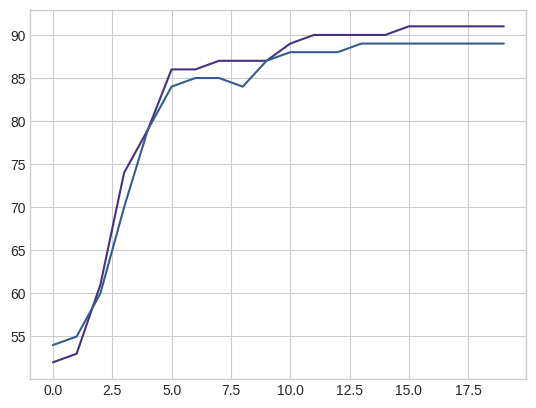

In [ ]:
sns.lineplot(x=[i for i in range(20)], y=train_list)
sns.lineplot(x=[i for i in range(20)], y=test_list)

[Text(0.5, 1.0, 'Loss 0.00012760422205143742')]

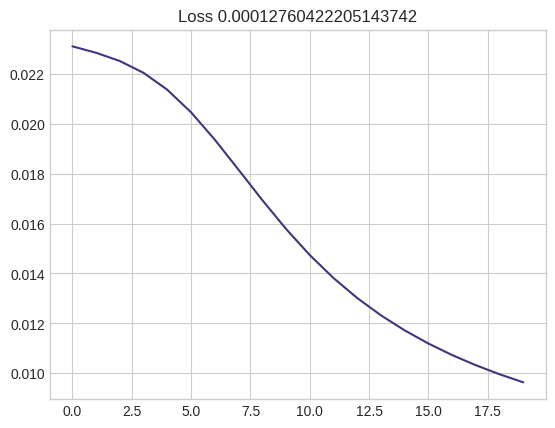

In [ ]:
sns.lineplot(x=[i for i in range(20)], y=loss_list).set(title='Loss 0.00012760422205143742')

[Text(0.5, 1.0, 'Loss 0.00013022156954668927')]

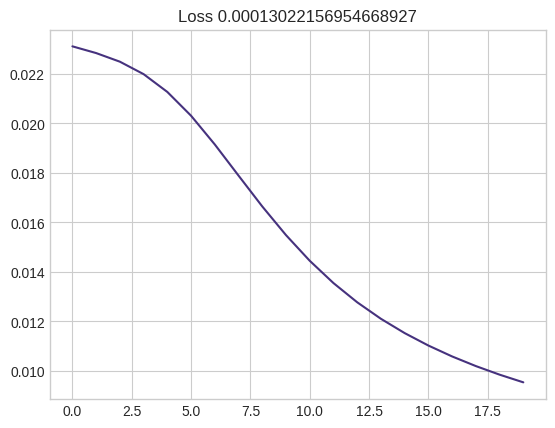

In [ ]:
sns.lineplot(x=[i for i in range(20)], y=loss_list).set(title='Loss 0.00013022156954668927')

[Text(0.5, 1.0, 'Loss 0.0002013597445353245')]

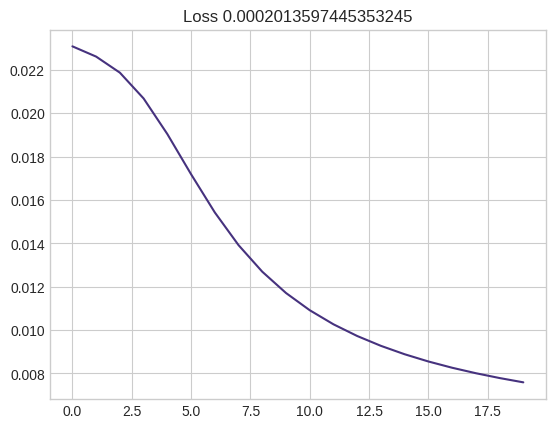

In [ ]:
sns.lineplot(x=[i for i in range(20)], y=loss_list).set(title='Loss 0.0002013597445353245')

[Text(0.5, 1.0, 'Loss 0.00014926566021498933')]

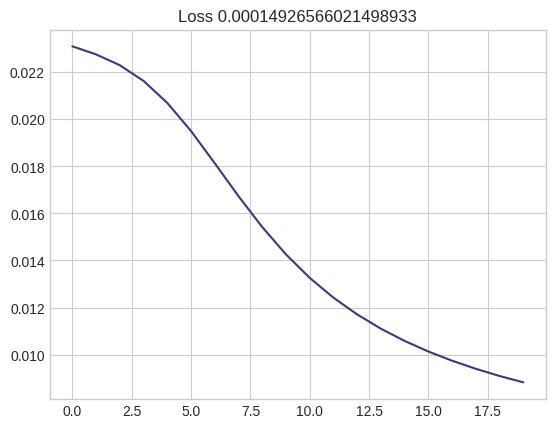

In [ ]:
sns.lineplot(x=[i for i in range(20)], y=loss_list).set(title='Loss 0.00014926566021498933')

[Text(0.5, 1.0, 'Loss 0.00013523158305498746')]

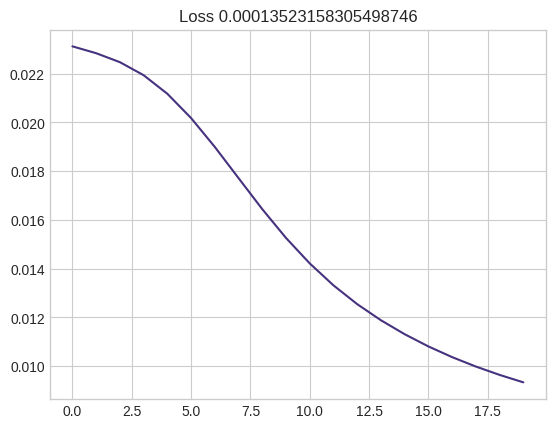

In [ ]:
sns.lineplot(x=[i for i in range(20)], y=loss_list).set(title='Loss 0.00013523158305498746')

## **SVM**

In [ ]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [ ]:
clf

SVC(kernel='linear')

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.875


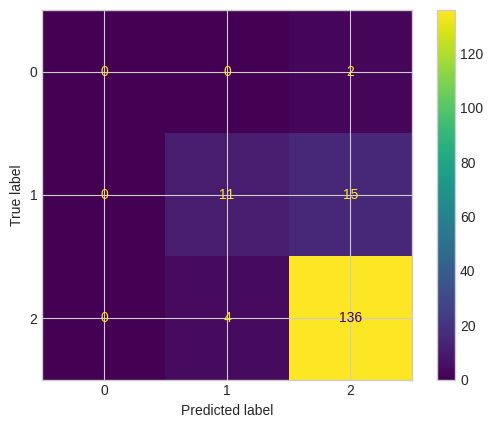

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

## **SVM dengan pembeneran akurasi**

In [ ]:
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
best_acc = -1
degree = [i for i in range(1,20)]
scale = ['scale', 'auto']
for sc in [1]:

  for i in range(100):
    c = 10**random.uniform(-5,5)
    coe = 10**random.uniform(-5,5)
    tol = 10**random.uniform(-5,5)
    print(f"cache : {c}, coe : {coe}, tol : {tol}", end=', ')
    reg = 10**random.uniform(-1,1)
    # print(f"Kernel : {kern}, reg : {reg}", end=', ')
    #Create a svm Classifier
    clf = svm.SVC(kernel='sigmoid',
                  C=c,
                  degree=1,
                  coef0=coe,
                  tol=tol) # Linear Kernel
    # clf = svm.SVC(kernel='sigmoid',
    #               C=1.5106108189353196,
    #               degree=1,
    #               coef0=0.647517407284433,
    #               tol=1.8359221883440502) # Linear Kernel

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    acc = accuracy_score(y_test, y_pred)
    # print("Train Accuracy:", train_acc)
    print("Test Accuracy:", acc)
    # print()
    if acc>best_acc:
      best_acc = acc
print(f"Best acc : {best_acc}")

cache : 6.663859479873222, coe : 0.0013015506274554193, tol : 0.780674048845557, Test Accuracy: 0.8605769230769231
cache : 57248.68978013657, coe : 29.69358229377136, tol : 2.1125923842300245, Test Accuracy: 0.34615384615384615
cache : 228.8273716098004, coe : 1768.3867753246875, tol : 1.5477333103026385, Test Accuracy: 0.3173076923076923
cache : 6.294235407668759e-05, coe : 1627.2605613811895, tol : 305.5494441642927, Test Accuracy: 0.34615384615384615
cache : 4.706470932782312, coe : 37834.55036386825, tol : 0.0007322655749322854, Test Accuracy: 0.3173076923076923
cache : 0.9317366783905271, coe : 1.5030272867882353, tol : 0.09224899992876798, Test Accuracy: 0.8485576923076923
cache : 5.917624850891354e-05, coe : 2382.106743942215, tol : 6.361625079432395, Test Accuracy: 0.34615384615384615
cache : 0.027759966277031457, coe : 4.003803324596167e-05, tol : 0.5511795491455026, Test Accuracy: 0.7307692307692307
cache : 7.656247764041577e-05, coe : 3.652147220139566, tol : 151.66047453451

In [ ]:
"""
sama tapi ganti preprocessing ke baru + k351
Best acc : 0.8452380952380952

tol : 1.8359221883440502, Test Accuracy: 0.7797619047619048
Best acc : 0.7797619047619048

coef : 0.647517407284433, Test Accuracy: 0.7678571428571429

Kernel : sigmoid
Train Accuracy: 0.8952095808383234
Test Accuracy: 0.7619047619047619

Kernel : sigmoid
Train Accuracy: 0.8712574850299402
Test Accuracy: 0.7559523809523809
"""

SyntaxError: invalid syntax (<ipython-input-30-2315753863>, line 2)

## **Logistic regression**

In [ ]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
train_acc = accuracy_score(y_train, logreg.predict(X_train))
acc = accuracy_score(y_test, y_pred)
print("Train Accuracy:", train_acc)
print("Test Accuracy:", acc)

Train Accuracy: 0.8952095808383234
Test Accuracy: 0.8690476190476191


In [ ]:
logreg

LogisticRegression(random_state=16)

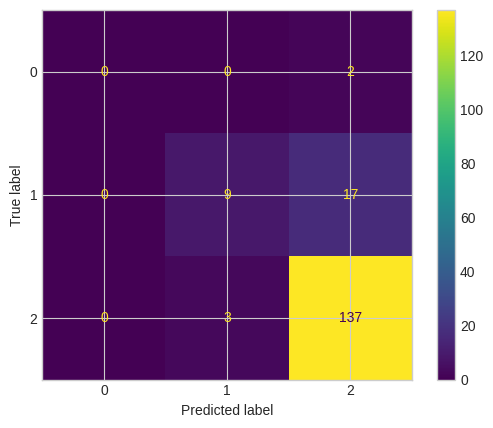

In [ ]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

## **Logistic regresion pembenaran akurasi**

In [ ]:
pen = ['l2', 'elasticnet', None]
best_acc = -1

for sc in [1]:
  for penalty in range(1000):
    c = 10**random.uniform(-5,5)
    print(f"interc : {c}", end=', ')
    # print(f"Kernel : {kern}, reg : {reg}", end=', ')
    #Create a svm Classifier
  # instantiate the model (using the default parameters)
    logreg = LogisticRegression(random_state=16,
                               C=c )

    # fit the model with data
    logreg.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = logreg.predict(X_test)
    train_acc = accuracy_score(y_train, logreg.predict(X_train))
    acc = accuracy_score(y_test, y_pred)
    # print("Train Accuracy:", train_acc)
    print("Test Accuracy:", acc)
    # print()
    if acc>best_acc:
      best_acc = acc
print(f"Best acc : {best_acc}")

interc : 9457.515544125734, Test Accuracy: 0.9302884615384616
interc : 4626.271704181132, Test Accuracy: 0.9158653846153846
interc : 4.701709321896985, Test Accuracy: 0.8918269230769231
interc : 210.97888885830434, Test Accuracy: 0.9038461538461539
interc : 0.0003430489196940935, Test Accuracy: 0.3173076923076923
interc : 1238.1330402115682, Test Accuracy: 0.9086538461538461
interc : 200.18733441124857, Test Accuracy: 0.8990384615384616
interc : 0.01836214254095938, Test Accuracy: 0.8653846153846154
interc : 4.224122280081382, Test Accuracy: 0.8918269230769231
interc : 386.30724859490516, Test Accuracy: 0.9110576923076923
interc : 1662.4981701365184, Test Accuracy: 0.9302884615384616
interc : 0.00015225568152195984, Test Accuracy: 0.3173076923076923
interc : 0.00033877995538515596, Test Accuracy: 0.3173076923076923
interc : 0.0034818833305102666, Test Accuracy: 0.7884615384615384
interc : 1.030073228293325, Test Accuracy: 0.8990384615384616
interc : 1677.8503299553383, Test Accuracy: 0

In [ ]:
"""
ga ubah apa apa tapi feature scaling
Best acc : 0.8392857142857143


Best acc : 0.7559523809523809
"""

'\nga ubah apa apa tapi feature scaling\nBest acc : 0.8392857142857143\n\n\nBest acc : 0.7559523809523809\n'